
# RPC Prediction with XGBoost — End-to-end Project

**Work** in this notebook will demonstrate how to build, train, and deploy an XGBoost model for RPC prediction tasks:
- How to generate a small synthetic dataset for RPC (Right Party Contact) prediction
- Preprocess data (imputation + scaling)
- Train and tune an XGBoost classifier using `RandomizedSearchCV`
- Evaluate model with AUC, precision, recall, F1
- Save model artifacts for deployment
- Minimal Flask example and deployment instructions to host the model (e.g., Render/Heroku/Gunicorn)

> This notebook is designed for interview/demo purposes: it uses only **3 features** for clarity and reproducibility.


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
import joblib
import xgboost as xgb





## 

Dataset with **3 features**:
- `avg_payment_delay` (days late)
- `payment_ratio` (0-1)
- `prior_contact_rate` (0-1)

The target is `rpc_label` (0/1).


In [29]:
df = pd.read_csv('../data/Rpc3var_data.csv')


## 2) Quick EDA

Inspect distributions and class balance. This helps understand whether scaling or class handling is needed.


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_payment_delay,20000.0,17.087448,18.432323,0.017302,4.139932,7.931323,35.024650,59.994897
payment_ratio,20000.0,0.586460,0.271254,0.000000,0.334044,0.641607,0.797956,1.000000
prior_contact_rate,20000.0,0.298268,0.180390,0.000002,0.158114,0.267581,0.423001,0.929619
rpc_label,20000.0,0.497950,0.500008,0.000000,0.000000,0.000000,1.000000,1.000000


### Class Distribution Analysis

Check the balance between RPC success (1) and failure (0) classes. This helps us understand:
- Whether we have a balanced dataset or class imbalance
- If we need to apply class weighting or sampling techniques
- The baseline accuracy we should expect from our model

In [31]:
df['rpc_label'].value_counts(normalize=True).rename('proportion')

rpc_label
0    0.50205
1    0.49795
Name: proportion, dtype: float64


## 3) Preprocessing pipeline

We will impute missing values (median) and scale features (StandardScaler). XGBoost doesn't require scaling, but it's good practice if you later replace the model with some other model.


In [32]:

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

RND = 42
np.random.seed(RND)

FEATURES = ['avg_payment_delay','payment_ratio','prior_contact_rate']

preproc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = df[FEATURES].values
y = df['rpc_label'].values
X_proc = preproc.fit_transform(X)
X_proc[:5]


array([[-0.814701  ,  1.35196515,  1.14444696],
       [-0.4073917 , -0.04530055,  1.24879319],
       [-0.71391739,  0.25514708,  1.46158881],
       [-0.13469402,  0.06774198,  0.21700911],
       [-0.90782613, -0.09989674,  0.2968287 ]])

## 4) Train/test split and hyperparameter tuning

We use `RandomizedSearchCV` with a richer search space (depth, estimators, gamma, min_child_weight) to improve separation around the 0.50 decision boundary while keeping the run time reasonable. Stratified folds preserve class balance.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.2, stratify=y, random_state=RND
)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=RND, n_jobs=4
)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.02, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.75, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

rs = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='roc_auc',
    cv=cv,
    n_jobs=4,
    random_state=RND,
    verbose=1
)

rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
print('Best CV AUC:', rs.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params: {'subsample': 0.75, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 1.0}
Best CV AUC: 0.7397275402883157
Best params: {'subsample': 0.75, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 1.0}
Best CV AUC: 0.7397275402883157



## 5) Evaluate on holdout test set


{
  "auc": 0.7441359061744988,
  "accuracy": 0.6985,
  "precision": 0.6419797687861272,
  "recall": 0.8920682730923695,
  "f1": 0.7466386554621849
}


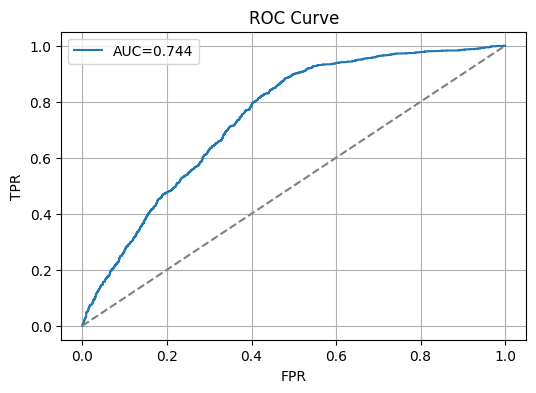

In [34]:
best = rs.best_estimator_
y_proba = best.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

metrics = {
    'auc': float(roc_auc_score(y_test, y_proba)),
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred)),
    'recall': float(recall_score(y_test, y_pred)),
    'f1': float(f1_score(y_test, y_pred))
}
print(json.dumps(metrics, indent=2))

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC={metrics["auc"]:.3f}')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)
plt.show()



## 6) Save model & preprocessing pipeline

We will save:
- `preproc.joblib` (preprocessing pipeline)
- XGBoost native model JSON via `best.get_booster().save_model(...)`
- a combined sklearn-like pipeline via `joblib` for easy serving


In [ ]:
out_dir = 'artifact_rpc_model'
os.makedirs(out_dir, exist_ok=True)

preproc_path = os.path.join(out_dir, 'preproc.joblib')
joblib.dump(preproc, preproc_path)
print('Saved preproc ->', preproc_path)

xgb_model_path = os.path.join(out_dir, 'rpc_xgb_model.json')
best.get_booster().save_model(xgb_model_path)
print('Saved xgb model ->', xgb_model_path)

pipeline = Pipeline([('preproc', preproc), ('xgb', best)])
pipeline_path = os.path.join(out_dir, 'rpc_pipeline.joblib')
joblib.dump(pipeline, pipeline_path)
print('Saved pipeline ->', pipeline_path)

meta = {'features': FEATURES, 'metrics_test': metrics, 'best_params': rs.best_params_}
with open(os.path.join(out_dir, 'meta.json'), 'w') as f:
    json.dump(meta, f, indent=2)
#print('Saved meta ->', os.path.join(out_dir, 'meta.json'))


Saved preproc -> artifact_rpc_model\preproc.joblib
Saved xgb model -> artifact_rpc_model\rpc_xgb_model.json
Saved pipeline -> artifact_rpc_model\rpc_pipeline.joblib
Saved meta -> artifact_rpc_model\meta.json


In [40]:
batch_instances = [
    {"name": "Excellent Account", "features": [2.0, 0.98, 0.85]},
    {"name": "At-Risk Account", "features": [18.5, 0.42, 0.25]},
    {"name": "Average Account", "features": [9.0, 0.61, 0.45]},
    {"name": "Low Likelihood Account", "features": [22.0, 0.30, 0.10]},
]

X_batch = np.array([row["features"] for row in batch_instances])
probs_batch = pipeline.predict_proba(X_batch)[:, 1]
preds_batch = (probs_batch >= 0.5).astype(int)

results = []
for row, prob, pred in zip(batch_instances, probs_batch, preds_batch):
    label = "Contact" if pred == 1 else "No Contact"
    confidence = prob if pred == 1 else (1 - prob)
    results.append({
        "name": row["name"],
        "features": row["features"],
        "probability": float(prob),
        "prediction": label
        ,"confidence": float(confidence),
    })

pd.DataFrame(results)

,name,features,probability,prediction,confidence
0,Excellent Account,"[2.0, 0.98, 0.85]",0.792157,Contact,0.792157
1,At-Risk Account,"[18.5, 0.42, 0.25]",0.446612,No Contact,0.553388
2,Average Account,"[9.0, 0.61, 0.45]",0.613698,Contact,0.613698
3,Low Likelihood Account,"[22.0, 0.3, 0.1]",0.313329,No Contact,0.686671
